In [ ]:
# Cell 1: Cài đặt và Kiểm tra Môi trường

# Cài đặt các thư viện cần thiết
!pip install ultralytics roboflow -q

# Kiểm tra GPU
!nvidia-smi

# Import các thư viện
import os
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image, display

# Kiểm tra cài đặt của ultralytics
import ultralytics
ultralytics.checks()

# Thiết lập thư mục làm việc
HOME = os.getcwd()
print(f"\nThư mục làm việc hiện tại: {HOME}")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.4/112.6 GB disk)

Thư mục làm việc hiện tại: /content


In [ ]:
# Cell 2: Tải Dataset từ Roboflow

ROBOFLOW_API_KEY = "5xYOAL5gtID867MFlM8E"
WORKSPACE_ID = "fruit-detection-ubxth"
PROJECT_ID = "fruit-detection-148l2"
VERSION_NUMBER = 4

# Khởi tạo và tải dataset
try:
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    project = rf.workspace(WORKSPACE_ID).project(PROJECT_ID)
    dataset = project.version(VERSION_NUMBER).download("yolov8")
    DATASET_PATH = dataset.location
    print(f"Dataset đã được tải về tại: {DATASET_PATH}")
    # In ra file cấu hình để kiểm tra
    %cat {DATASET_PATH}/data.yaml
except Exception as e:
    print(f"Lỗi khi tải dataset: {e}")
    print("Vui lòng kiểm tra lại API Key và các ID.")
    DATASET_PATH = None

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fruit-Detection-4 in yolov8:: 100%|██████████| 3052/3052 [00:04<00:00, 705.73it/s]


Dataset đã được tải về tại: /content/Fruit-Detection-4
names:
- 1st_grade_mango
- 2nd_grade_mango
- 3rd_grade_mango
nc: 3
roboflow:
  license: CC BY 4.0
  project: fruit-detection-148l2
  url: https://universe.roboflow.com/fruit-detection-ubxth/fruit-detection-148l2/dataset/4
  version: 4
  workspace: fruit-detection-ubxth
test: ../test/images
train: ../train/images
val: ../valid/images


In [ ]:
# Cell 3: Huấn luyện Mô hình YOLOv8

if DATASET_PATH:
    # Lệnh huấn luyện
    !yolo task=detect mode=train \
    model='yolov8n.pt' \
    data='{DATASET_PATH}/data.yaml' \
    epochs=100 \
    imgsz=640 \
    plots=True \
    project='yolov8_training' \
    name='run1'
else:
    print("Không thể bắt đầu huấn luyện vì không có dataset.")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Fruit-Detection-4/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=run1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True

In [ ]:
# Cell 4: Đánh giá Mô hình trên Tập Validation

path_to_best_weights = 'yolov8_training/run1/weights/best.pt'

if os.path.exists(path_to_best_weights):
    !yolo task=detect mode=val \
    model='{path_to_best_weights}' \
    data='{DATASET_PATH}/data.yaml'
else:
    print("Không tìm thấy file trọng số 'best.pt'.")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2896.8±1276.9 MB/s, size: 579.0 KB)
val: Scanning /content/Fruit-Detection-4/valid/labels.cache... 251 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 251/251 4.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 1.6it/s 9.9s
                   all        251       1854      0.947      0.945      0.983      0.911
       1st_grade_mango        194       1797      0.912      0.861       0.96      0.854
       2nd_grade_mango         39         39      0.961      0.974      0.993      0.936
       3rd_grade_mango         18         18       0.97          1      0.995      0.945
Speed: 2.5ms preprocess, 5.8ms inference, 0.0ms loss, 7.0ms postprocess per image
Results saved to /content/runs/detect/val
💡 L

In [ ]:
# Cell 5: Chạy Dự đoán trên Ảnh Test

# Chạy dự đoán trên tất cả các ảnh trong thư mục test
# conf=0.25: Chỉ hiển thị các phát hiện có độ tin cậy trên 25%
if os.path.exists(path_to_best_weights):
    !yolo task=detect mode=predict \
    model='{path_to_best_weights}' \
    conf=0.25 \
    source='{DATASET_PATH}/test/images' \
    save=True
else:
    print("Không tìm thấy file trọng số 'best.pt' để chạy dự đoán.")

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/126 /content/Fruit-Detection-4/test/images/5471316-hd_1920_1080_24fps_mp4-0024_jpg.rf.52345daf879ecf5ad4ab43e50ca176be.jpg: 384x640 14 1st_grade_mangos, 43.4ms
image 2/126 /content/Fruit-Detection-4/test/images/5471316-hd_1920_1080_24fps_mp4-0031_jpg.rf.3a3a39fc518cf1bea6c6502b3a621a40.jpg: 384x640 13 1st_grade_mangos, 6.3ms
image 3/126 /content/Fruit-Detection-4/test/images/5471316-hd_1920_1080_24fps_mp4-0087_jpg.rf.ab4976dd91890e7eab3f6a424375ed6d.jpg: 384x640 13 1st_grade_mangos, 5.7ms
image 4/126 /content/Fruit-Detection-4/test/images/5471316-hd_1920_1080_24fps_mp4-0109_jpg.rf.243c3e537fd1b8854ae4e632612598c3.jpg: 384x640 11 1st_grade_mangos, 5.7ms
image 5/126 /content/Fruit-Detection-4/test/images/5471316-hd_1920_1080_24fps_mp4-0152_jpg.rf.dce098f88b04a578d5b3ec67cf328be7.jpg: 384x640 13 1st_grade_mangos, 5.8ms


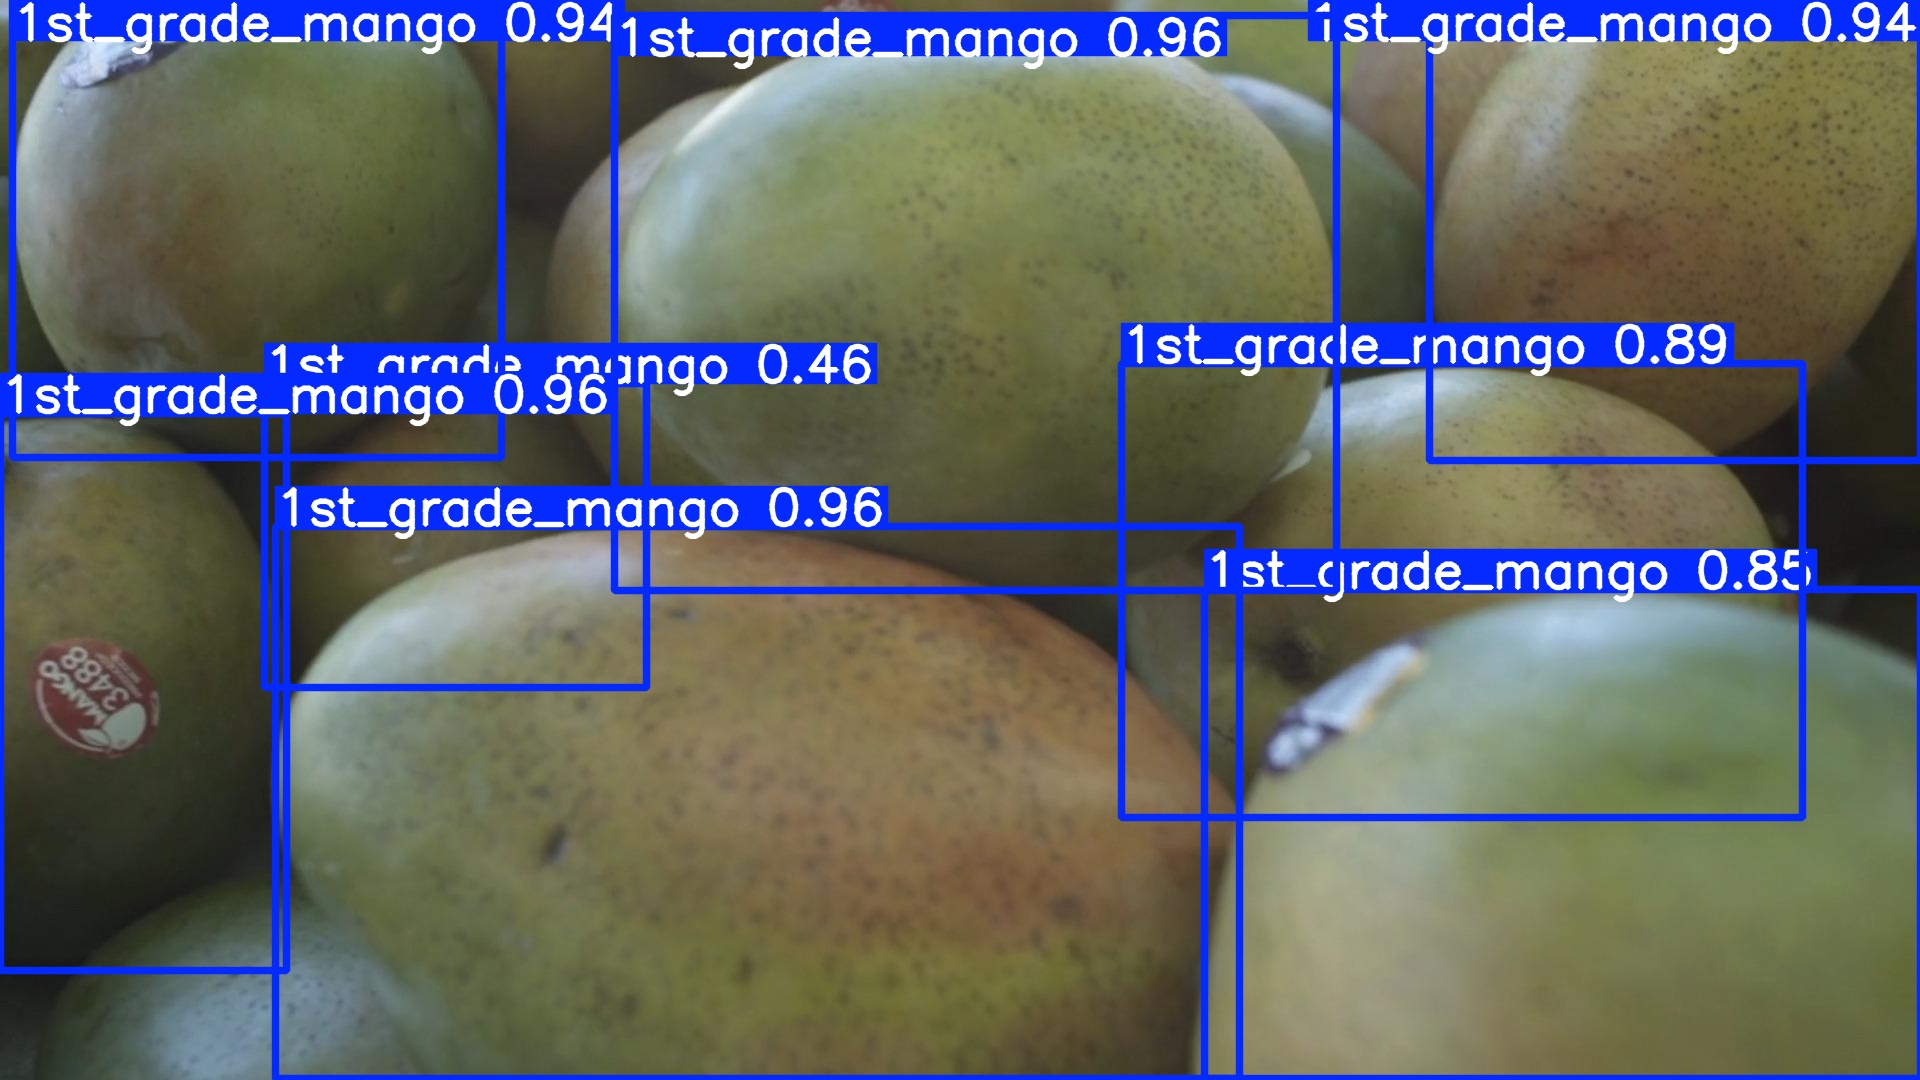

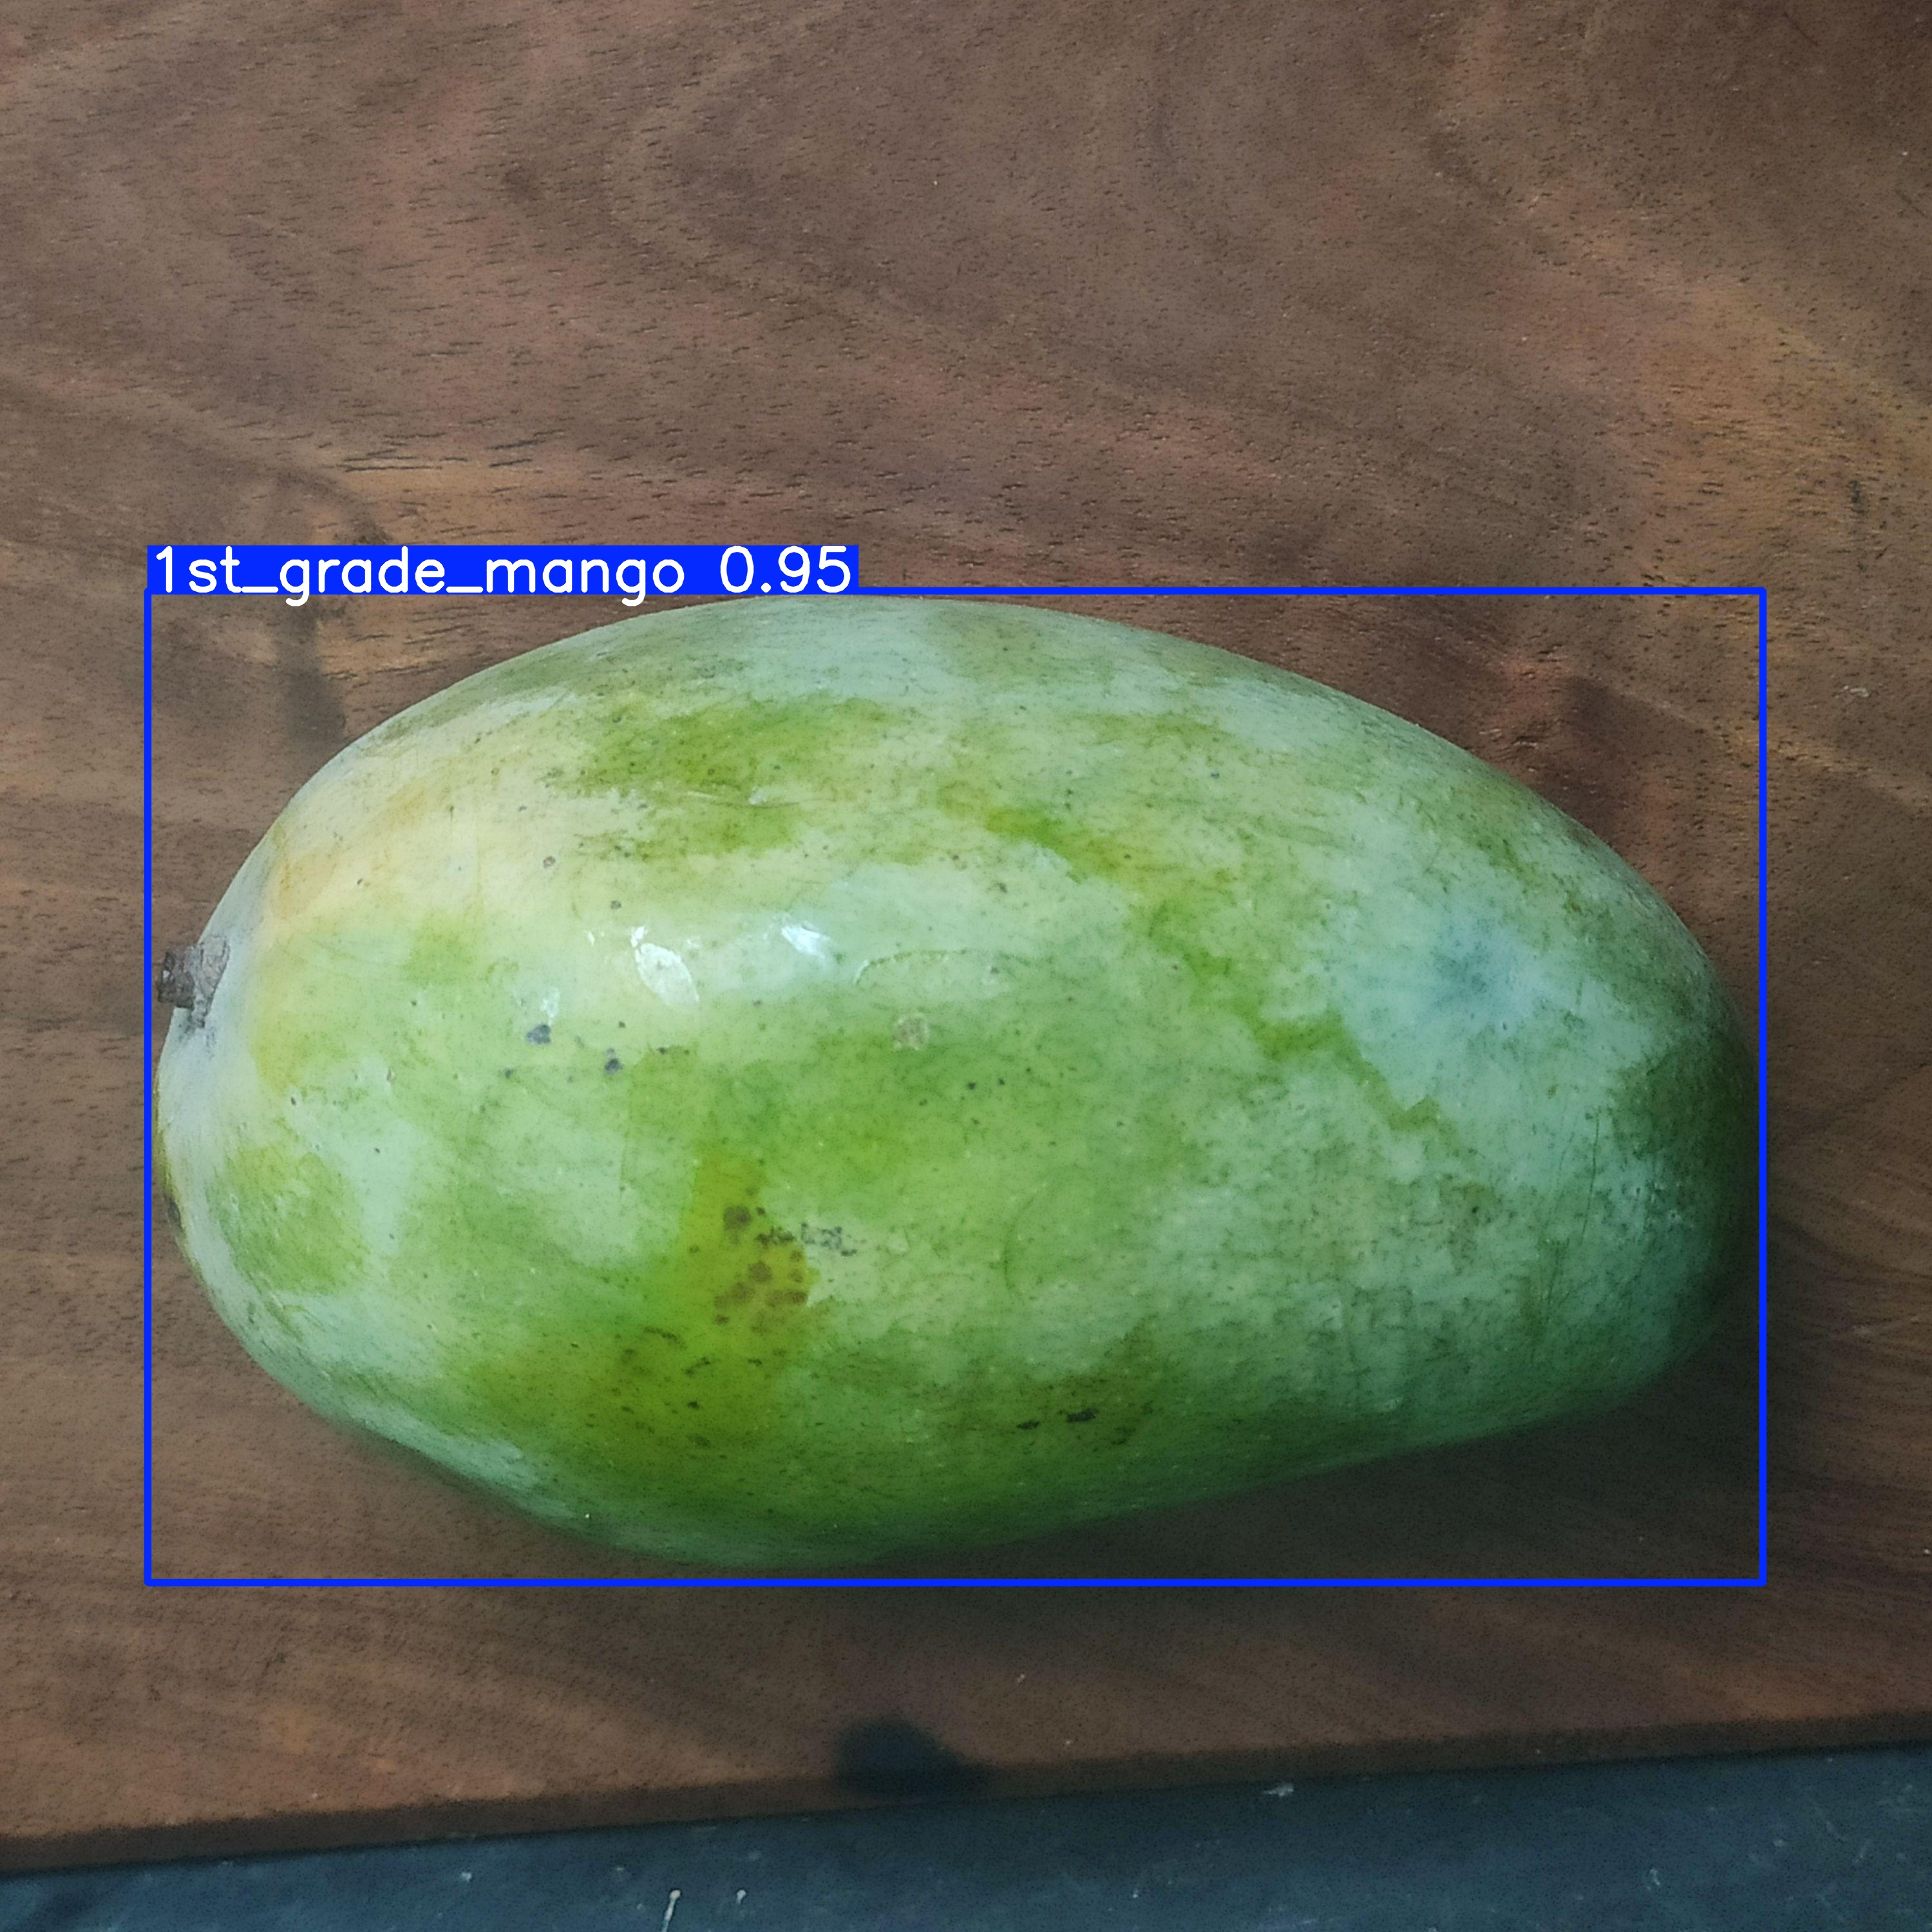

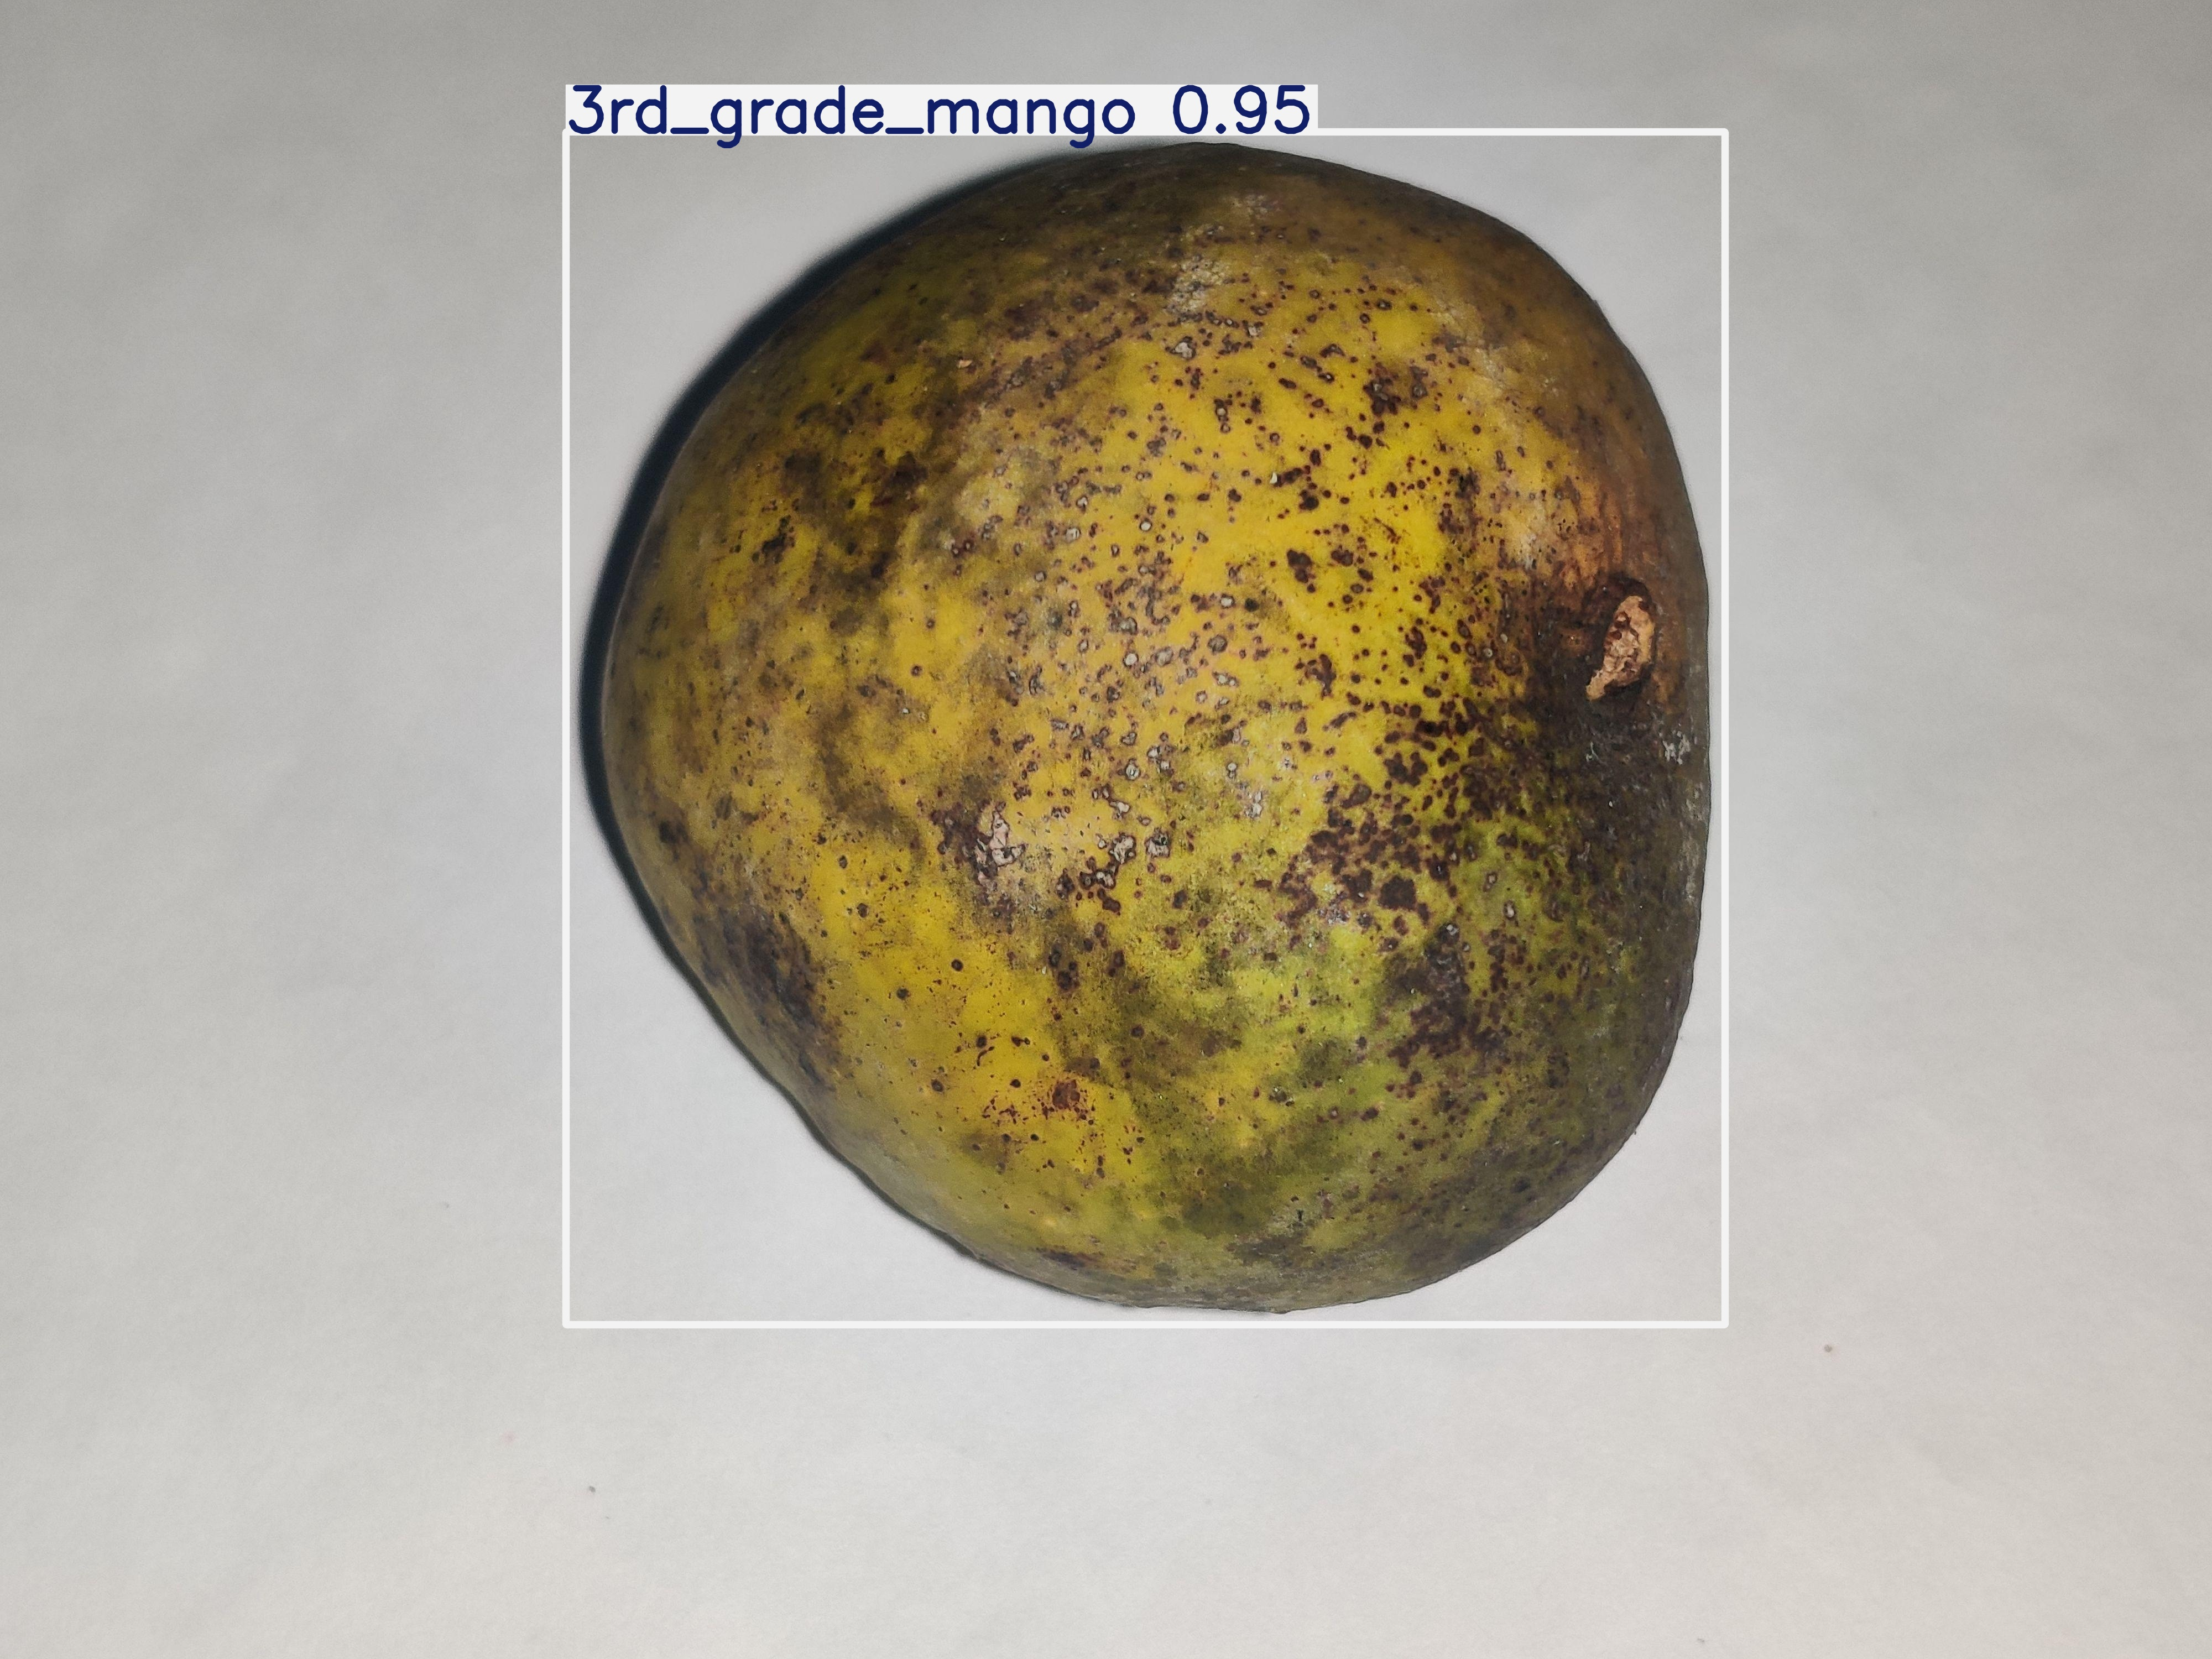

In [ ]:
# Cell 6: Xem Kết quả Dự đoán

import glob
import random

# Lấy đường dẫn của thư mục predict mới nhất
predict_folders = glob.glob('runs/detect/predict*')
latest_predict_folder = sorted(predict_folders, key=os.path.getmtime)[-1] if predict_folders else None

if latest_predict_folder:
    image_files = glob.glob(f'{latest_predict_folder}/*.jpg')
    random.shuffle(image_files)
    for image_file in image_files[:3]:
        display(Image(filename=image_file, width=600))
else:
    print("Không tìm thấy thư mục kết quả dự đoán.")